In [1]:
import pandas as pd
import numpy as np

In [2]:
# https://gist.github.com/ultragtx/6831eb04dfe9e6ff50d0f334bdcb847d
# calculating RSI (gives the same values as TradingView)
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
def RSI(series, period=14):
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    return 100 - 100 / (1 + rs)


# calculating Stoch RSI (gives the same values as TradingView)
# https://www.tradingview.com/wiki/Stochastic_RSI_(STOCH_RSI) 
def StochRSI(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.rolling(smoothK).mean()
    stochrsi_D = stochrsi_K.rolling(smoothD).mean()

    return stochrsi, stochrsi_K, stochrsi_D


# calculating Stoch RSI 
#  -- Same as the above function but uses EMA, not SMA
def StochRSI_EMA(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.ewm(span=smoothK).mean()
    stochrsi_D = stochrsi_K.ewm(span=smoothD).mean()

    return stochrsi, stochrsi_K, stochrsi_D

In [3]:
#Ichimoku code: https://stackoverflow.com/a/61282544
def ichimoku(df):
    #Tenkan Sen
    tenkan_max = df['High'].rolling(window = 9, min_periods = 0).max()
    tenkan_min = df['Low'].rolling(window = 9, min_periods = 0).min()
    df['tenkan_avg'] = (tenkan_max + tenkan_min) / 2

    #Kijun Sen
    kijun_max = df['High'].rolling(window = 26, min_periods = 0).max()
    kijun_min = df['Low'].rolling(window = 26, min_periods = 0).min()
    df['kijun_avg'] = (kijun_max + kijun_min) / 2

    #Senkou Span A
    #(Kijun + Tenkan) / 2 Shifted ahead by 26 periods
    df['senkou_a'] = ((df['kijun_avg'] + df['tenkan_avg']) / 2).shift(26)

    #Senkou Span B
    #52 period High + Low / 2
    senkou_b_max = df['High'].rolling(window = 52, min_periods = 0).max()
    senkou_b_min = df['Low'].rolling(window = 52, min_periods = 0).min()
    df['senkou_b'] = ((senkou_b_max + senkou_b_min) / 2).shift(52)

    #Chikou Span
    #Current close shifted -26
    df['chikou'] = (df['Close']).shift(-26)

In [4]:
from data_store import DataStore
import json
# Offline Loading
sig = "linkupusdt" + "@" + "1h" + "-" + str(1000) + "|" + "" + "-" + ""
DataStore.store[sig] = json.load(open("linkupusdt-1h-1000.json"))

In [5]:
data = DataStore.loadKlineFrame(symbol="linkupusdt", timeframe="1h")

In [6]:
rsi, k, d = StochRSI(data.Close)
data["K"] = k
data["D"] = d

ichimoku(data)

In [7]:
data.tail(2)

,OpenTime,Open,High,Low,Close,Volume,CloseTime,Quote-asset-volume,Number-of-trades,Taker-buy-base-asset-volume,Taker-buy-quote-asset-volumze,Ignore,K,D,tenkan_avg,kijun_avg,senkou_a,senkou_b,chikou
998,1625666400000,2.144,2.157,2.050,2.050,94293.68,1625669999999,198796.59967,625,50586.68,106880.14473,0.0,0.203201,0.301987,2.1215,2.0095,1.73125,1.6765,NaN
999,1625670000000,2.049,2.062,2.041,2.062,12938.25,1625673599999,26513.00835,67,8521.54,17489.85058,0.0,0.132203,0.226178,2.1215,2.0095,1.73425,1.6475,NaN


In [8]:
import matplotlib.pyplot as plt

In [9]:
def theme(figure, axList):
    for ax in axList:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(colors='white', which='both')
        ax.set_facecolor("#0e101f")
        plt.setp(ax.get_title(), color='white')
        legend = ax.get_legend()
        if legend:
            frame = legend.get_frame()
            if frame:
                frame.set_facecolor('#202446')
                frame.set_edgecolor('#2D3262')
            for text in legend.get_texts():
                text.set_color("white")
    figure.set_facecolor("#0e101f")

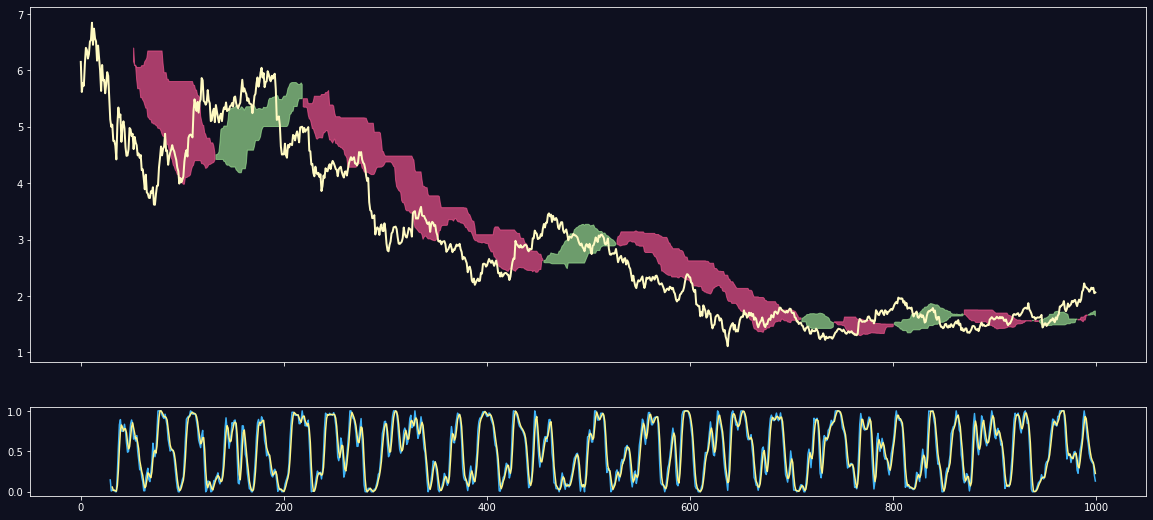

In [10]:
# Plotting Code: https://stackoverflow.com/a/54862983
fig, axs = plt.subplots(2, 1,sharex=True,figsize = (20,9), gridspec_kw={'height_ratios': [4, 1]})

ax = axs[0]
ax.plot(data.index, data.Close,linewidth=2, color="#FFFAC2")
ax.fill_between(data.index,data.senkou_a,data.senkou_b,where = data.senkou_a >= data.senkou_b, color = '#9EE493AA')
ax.fill_between(data.index,data.senkou_a,data.senkou_b,where = data.senkou_a < data.senkou_b, color = '#F75590AA')

ax = axs[1]
ax.plot(data.index, data.K, color="#3DB1F5")
ax.plot(data.index, data.D, color="#FFF689")
theme(fig, axs)

In [11]:
# RSI-Stochastic CrossOver; src: https://pythonforfinance.net/2017/10/10/stochastic-oscillator-trading-strategy-backtest-in-python/
crossDown = ((data['K'] < data['D']) & (data['K'].shift(1) > data['D'].shift(1)))
crossUp = ((data['K'] > data['D']) & (data['K'].shift(1) < data['D'].shift(1)))
# Cloud State
cloudIsUp = (data['Close'] < data['senkou_a']) & (data['Close'] < data['senkou_b'])
cloudIsDown = (data['Close'] > data['senkou_a']) & (data['Close'] > data['senkou_b'])
# Threshold
rsiUpThresh = data['D'] > 0.7
rsiDownThresh = data['D'] < 0.3

In [12]:
data['Long'] = cloudIsUp & crossUp & rsiDownThresh
data['Short'] = cloudIsDown & crossDown & rsiUpThresh

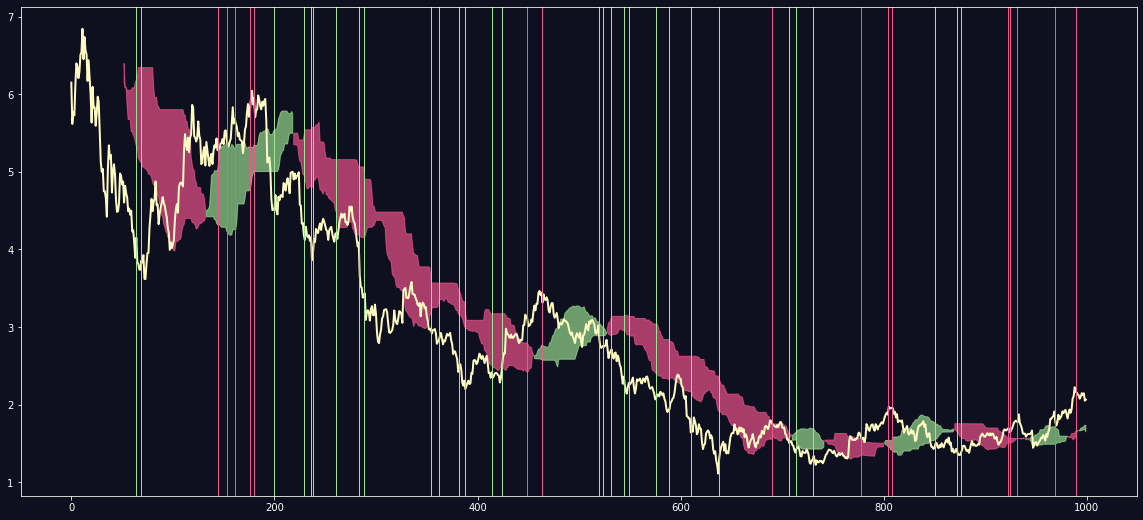

In [13]:
fig,ax = plt.subplots(1,1,sharex=True,figsize = (20,9))
ax.plot(data.index, data.Close,linewidth=2, color="#FFFAC2")

ax.fill_between(data.index,data.senkou_a,data.senkou_b,where = data.senkou_a >= data.senkou_b, color = '#9EE493AA')
ax.fill_between(data.index,data.senkou_a,data.senkou_b,where = data.senkou_a < data.senkou_b, color = '#F75590AA')

dx = data[data['Long'] == True]
dy = data[data['Short'] == True]
for i in range(len(dx)):
    plt.axvline(dx.iloc[i].name, color="#9EE493", lw=1)
for i in range(len(dy)):
    plt.axvline(dy.iloc[i].name, color="#F75590", lw=1)

theme(fig, [ax])

In [14]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [15]:
cloudD = ctrl.Antecedent(np.arange(0, 100, 1), 'cloud-state')
rsiV = ctrl.Antecedent(np.arange(0, 100, 1), 'rsi-value')
crossOver = ctrl.Antecedent(np.arange(0, 100, 1), 'cross-over')
position = ctrl.Consequent(np.arange(0, 100, 1), 'position')

In [16]:
cloudD.automf(3)
rsiV.automf(3)
crossOver.automf(3)
position.automf(3)

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
from skfuzzy.control.visualization import FuzzyVariableVisualizer

def viz(var, sim=None):
    fig, ax = FuzzyVariableVisualizer(var).view(sim=sim)
    theme(fig, [ax])

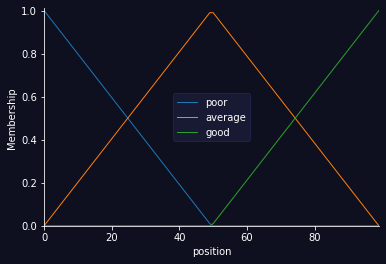

In [19]:
viz(position)

In [20]:
rule1 = ctrl.Rule(rsiV['poor'] & crossOver['good'], position['good'])
rule2 = ctrl.Rule(rsiV['good'] & crossOver['poor'], position['poor'])
rule3 = ctrl.Rule(cloudD['good'] & crossOver['poor'], position['poor'])
rule4 = ctrl.Rule(cloudD['poor'] & crossOver['good'], position['good'])
rule5 = ctrl.Rule(cloudD['poor'] & rsiV['poor'] & crossOver['good'], position['good'])
rule6 = ctrl.Rule(cloudD['good'] & rsiV['good'] & crossOver['poor'], position['poor'])
rule7 = ctrl.Rule(cloudD['average'] & rsiV['average'] & crossOver['average'], position['average'])
rule8 = ctrl.Rule(cloudD['good'] & rsiV['good'] & crossOver['good'], position['average'])
rule9 = ctrl.Rule(cloudD['poor'] & rsiV['poor'] & crossOver['poor'], position['average'])

pos_ctrl1 = ctrl.ControlSystem([rule1, rule2, rule3,
                                rule4, rule5, rule6,
                                rule7, rule8, rule9])

In [21]:
from skfuzzy.control.visualization import ControlSystemVisualizer
import networkx as nx

# https://www.python-graph-gallery.com/321-custom-networkx-graph-appearance
def vizR(rule):
    graph = rule.graph
    fig, ax = plt.subplots()
    nx.draw(graph, with_labels=False, node_size=200, node_color="#FFF689", node_shape="o", alpha=0.8, linewidths=4, width=1, edge_color="#3DB1F5", ax=ax)
    theme(fig, [ax])

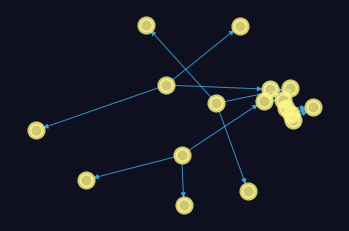

In [22]:
vizR(rule7)

In [23]:
cloudD2 = ctrl.Antecedent(np.arange(0, 100, 1), 'cloud-state')
rsiV2 = ctrl.Antecedent(np.arange(0, 100, 1), 'rsi-value')
crossOver2 = ctrl.Antecedent(np.arange(0, 100, 1), 'cross-over')
position2 = ctrl.Consequent(np.arange(0, 100, 1), 'position')

cloudD2.automf(5)
rsiV2.automf(5)
crossOver2.automf(5)
position2.automf(5)

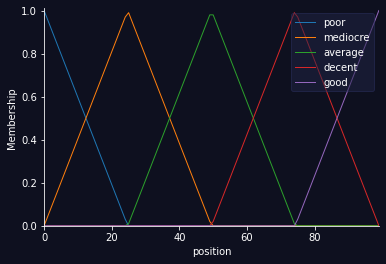

In [24]:
viz(position2)

In [25]:
dC = cloudD2['poor'] | cloudD2['mediocre']
uC = cloudD2['decent'] | cloudD2['good']

r1 = ctrl.Rule(dC & rsiV2['poor'] & crossOver2['good'], position2['good'])
r2 = ctrl.Rule(dC & rsiV2['mediocre'] & crossOver2['good'], position2['decent'])
r3 = ctrl.Rule(dC & rsiV2['poor'] & crossOver2['mediocre'], position2['decent'])

r4 = ctrl.Rule(uC & rsiV2['good'] & crossOver2['poor'], position2['poor'])
r5 = ctrl.Rule(uC & rsiV2['decent'] & crossOver2['poor'], position2['mediocre'])
r6 = ctrl.Rule(uC & rsiV2['good'] & crossOver2['decent'], position2['mediocre'])

r7 = ctrl.Rule(cloudD2['average'] & rsiV2['average'] & crossOver2['average'], position2['average'])
r8 = ctrl.Rule(uC & rsiV2['good'] & crossOver2['average'], position2['average'])
r9 = ctrl.Rule(dC & rsiV2['average'] & crossOver2['mediocre'], position2['average'])
r10 = ctrl.Rule(uC & rsiV2['average'] & crossOver2['decent'], position2['average'])
r11 = ctrl.Rule(dC & rsiV2['poor'] & crossOver2['average'], position2['average'])


r12 = ctrl.Rule(cloudD2['average'] & rsiV2['good'] & crossOver2['poor'], position2['mediocre'])
r13 = ctrl.Rule(cloudD2['average'] & rsiV2['poor'] & crossOver2['good'], position2['decent'])


r14 = ctrl.Rule(dC & rsiV2['good'] & crossOver2['poor'], position2['mediocre'])
r15 = ctrl.Rule(uC & rsiV2['poor'] & crossOver2['good'], position2['decent'])
r16 = ctrl.Rule(crossOver2['average'], position2['average'])

pos_ctrl2 = ctrl.ControlSystem([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16])

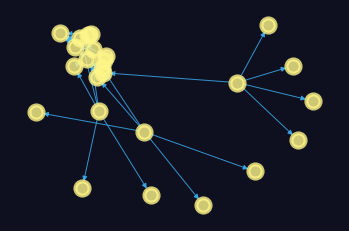

In [26]:
vizR(r8)

In [27]:
pos = ctrl.ControlSystemSimulation(pos_ctrl2)
pos.input['cloud-state'] = 90
pos.input['rsi-value'] = 50
pos.input['cross-over'] = 50
pos.compute()

49.5


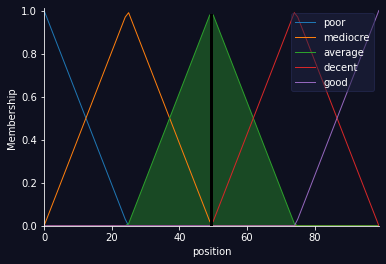

In [28]:
print(pos.output['position'])
viz(position2, sim=pos)

In [29]:
def plotSerie(s):
    fig, ax = plt.subplots()
    s.plot(ax=ax, color='#FFF689')
    theme(fig, [ax])

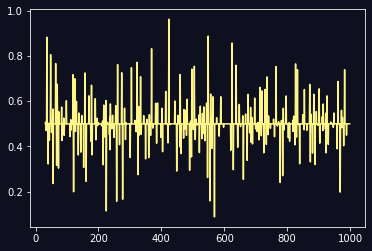

In [30]:
dK = (data.K - data.D)
dK = abs(dK)
crossV = (crossDown * -1 *  dK) + (crossUp * dK)

crossV[crossV > 0.2] = 0.2
crossV[crossV < -0.2] = -0.2
crossV = crossV + 0.2
crossV = crossV * (1/0.4) 

data["cross-over"] = crossV

plotSerie(crossV)

In [31]:
cdata = data.dropna()

In [32]:
cdata.head(3)

,OpenTime,Open,High,Low,Close,Volume,CloseTime,Quote-asset-volume,Number-of-trades,Taker-buy-base-asset-volume,...,K,D,tenkan_avg,kijun_avg,senkou_a,senkou_b,chikou,Long,Short,cross-over
52,1622260800000,4.898,4.963,4.539,4.604,35609.94,1622264399999,168203.20476,844,16087.47,...,0.651239,0.792312,4.7735,5.1505,6.15400,6.3960,4.452,False,False,0.5
53,1622264400000,4.604,4.932,4.592,4.820,70755.24,1622267999999,340907.44349,2984,26505.05,...,0.684374,0.724676,4.7605,5.0940,6.08875,6.0925,4.650,False,False,0.5
54,1622268000000,4.829,4.919,4.721,4.723,43585.30,1622271599999,210106.73573,488,19269.88,...,0.627055,0.654223,4.7615,4.9740,6.07250,6.0925,4.493,False,False,0.5


In [33]:
cdata["cloudIsUp"] = (cdata['Close'] < cdata['senkou_a']) & (cdata['Close'] < cdata['senkou_b'])
cdata["cloudIsDown"] = (cdata['Close'] > cdata['senkou_a']) & (cdata['Close'] > cdata['senkou_b'])

In [34]:
cdata["cloudState"] = 0.5
cdata["cloudState"] += cdata["cloudIsUp"] * 0.5
cdata["cloudState"] += cdata["cloudIsDown"] * -0.5
cdata.head(3)

,OpenTime,Open,High,Low,Close,Volume,CloseTime,Quote-asset-volume,Number-of-trades,Taker-buy-base-asset-volume,...,kijun_avg,senkou_a,senkou_b,chikou,Long,Short,cross-over,cloudIsUp,cloudIsDown,cloudState
52,1622260800000,4.898,4.963,4.539,4.604,35609.94,1622264399999,168203.20476,844,16087.47,...,5.1505,6.15400,6.3960,4.452,False,False,0.5,True,False,1.0
53,1622264400000,4.604,4.932,4.592,4.820,70755.24,1622267999999,340907.44349,2984,26505.05,...,5.0940,6.08875,6.0925,4.650,False,False,0.5,True,False,1.0
54,1622268000000,4.829,4.919,4.721,4.723,43585.30,1622271599999,210106.73573,488,19269.88,...,4.9740,6.07250,6.0925,4.493,False,False,0.5,True,False,1.0


In [35]:
res = [
    [],
    []
]
control_systems = [pos_ctrl1, pos_ctrl2]
c = [0, 0]
for i in range(len(cdata)):
    d = cdata.iloc[i]
    pos = None
    for idx, system in enumerate(control_systems):
        try:
            pos = ctrl.ControlSystemSimulation(system)
            pos.input['cloud-state'] = (1 - d['cloudState']) * 100
            pos.input['rsi-value'] = d['K'] * 100
            pos.input['cross-over'] = d['cross-over'] * 100
            pos.compute()
            res[idx].append(pos.output['position'])
        except:
            res[idx].append(50)
            c[idx] += 1
print("unmatched inputs system 1: ", c[0])
print("unmatched inputs system 2: ", c[1])

unmatched inputs system 1:  0
unmatched inputs system 2:  3


In [36]:
cdata["fuzz"] = res[0]
cdata["fuzz2"] = res[1]

In [37]:
def plotPositions(var, u, d):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(20,9))
    ax.plot(cdata.index, cdata.Close, linewidth=2, color="#FFFAC2")

    ax.fill_between(cdata.index,cdata.senkou_a,cdata.senkou_b,where = cdata.senkou_a >= cdata.senkou_b, color = '#9EE493AA')
    ax.fill_between(cdata.index,cdata.senkou_a,cdata.senkou_b,where = cdata.senkou_a < cdata.senkou_b, color = '#F75590AA')
    
    dx = cdata[cdata[var] > u]
    dy = cdata[cdata[var] < d]
    for i in range(len(dx)):
        plt.axvline(dx.iloc[i].name, color="#9EE493", lw=1)
    for i in range(len(dy)):
        plt.axvline(dy.iloc[i].name, color="#F75590", lw=1)

    theme(fig, [ax])

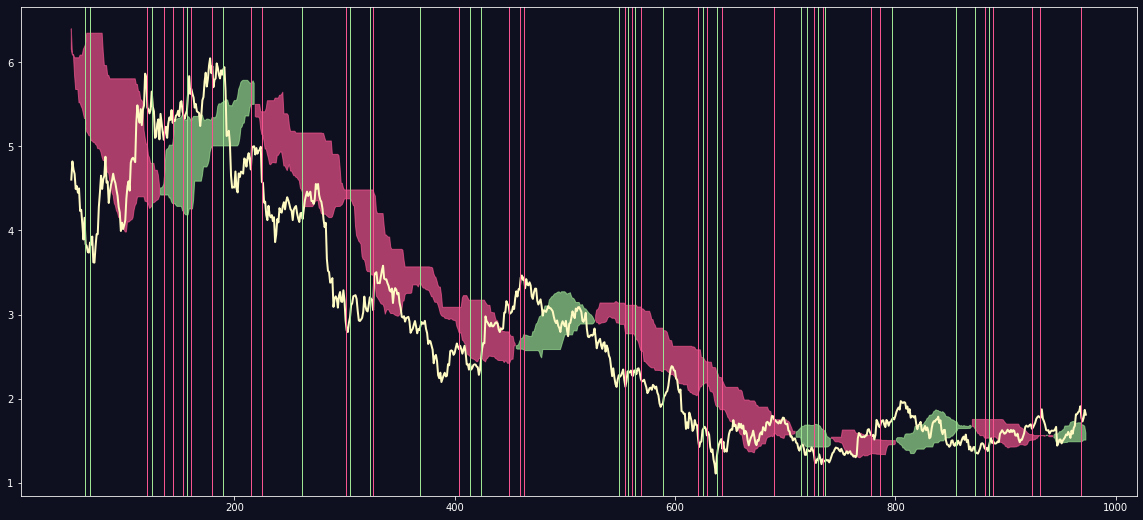

In [38]:
plotPositions("fuzz", 77, 23)

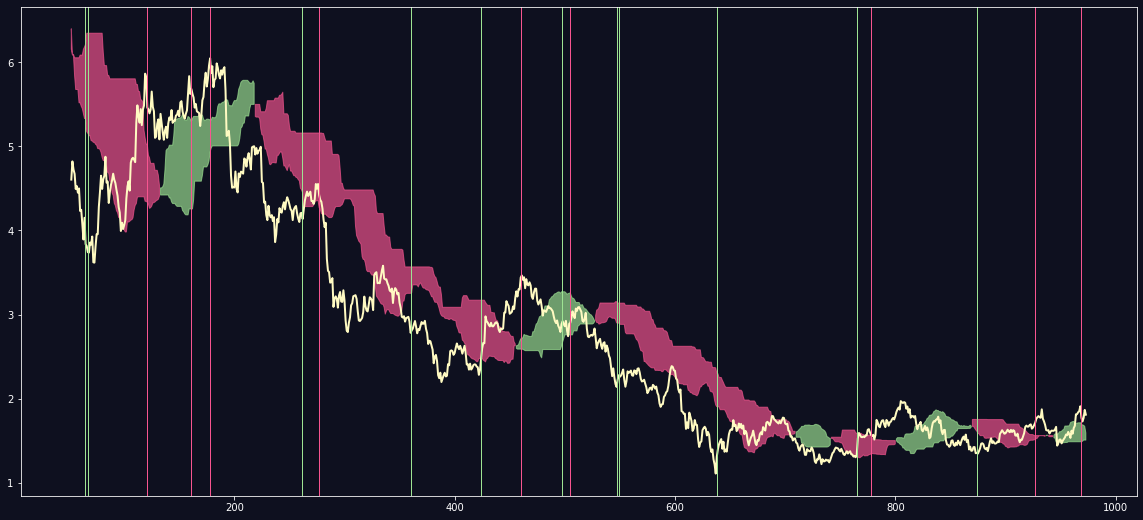

In [39]:
plotPositions("fuzz2", 60, 40)

In [40]:
# Eval Df for profits
def evalProfit(var, upT, downT):
    position = None
    positions = []
    profit = 1

    maxLoss = -0.2

    for i in range(len(cdata)):
        x = cdata.iloc[i]
        f = x[var]
        if f < downT and position is None:
            position = {
                "type": "short",
                "enter": x.Close,
                "check": x.High * 1.07, 
            }
        elif f > upT and position is None:
            position = {
                "type": "long",
                "enter": x.Close, 
                "check": x.Low * 0.93
            }
        elif position is not None:
            if position["type"] == "short":
                r = (position["enter"] - x.Close) / position["enter"]
                if f > upT:
                    position["exit"] = x.Close
                    positions.append(position)
                    profit *= (1 + r)
                    position = None
                elif r < maxLoss:
                    position["exit"] = position["enter"] * 1.1
                    r = maxLoss
                    positions.append(position)
                    profit *= (1 + r)
                    position = None
            elif position["type"] == "long":
                r = (x.Close - position["enter"]) / position["enter"]
                if f < downT:
                    position["exit"] = x.Close
                    positions.append(position)
                    profit *= (1 + r)
                    position = None
                elif r < maxLoss:
                    position["exit"] = position["enter"] * 0.9
                    r = maxLoss
                    positions.append(position)
                    profit *= (1 + r)
                    position = None
    return profit

In [41]:
evalProfit("fuzz", 77, 23)

1.8938727553469963

In [42]:
evalProfit("fuzz2", 60, 40)

3.827137542386544